## ICU LOS Classification Pipeline using RF, XGBoost, KNN and LR

## Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, RocCurveDisplay

# ===============================
# 1. Load dataset
# ===============================
analysis_df = pd.read_csv("icu_los_features_classification_subset.csv")

## ICU LOS Categories and Counts

In [3]:
import pandas as pd

# Add los_category to determine short and long hospital stay
analysis_df['los_category'] = np.where(analysis_df['icu_los_days'] >= 3, 1, 0)

# Map numeric labels to text for display
label_map = {0: 'Short', 1: 'Long'}

# Count occurrences
counts = analysis_df['los_category'].map(label_map).value_counts()

print(counts)

los_category
Short    57847
Long     30776
Name: count, dtype: int64


## Missing Data Analysis in ICU Dataset

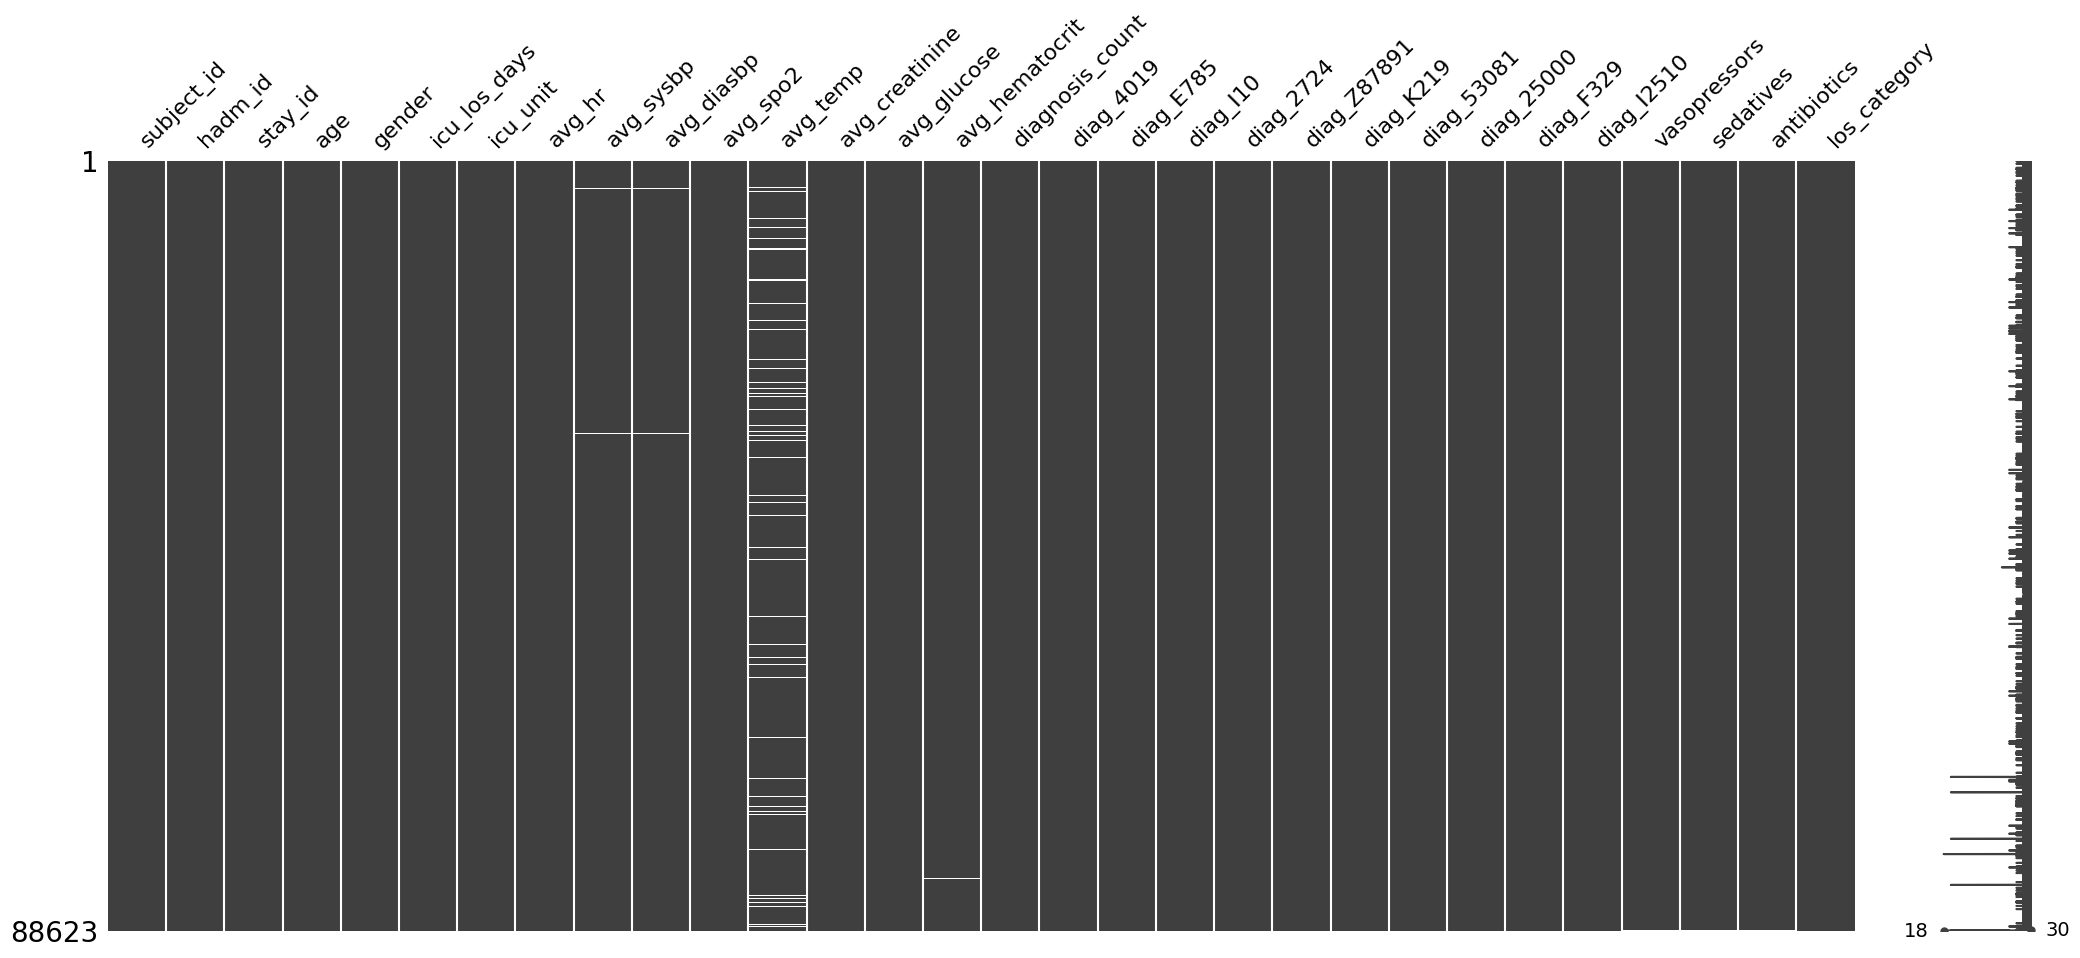

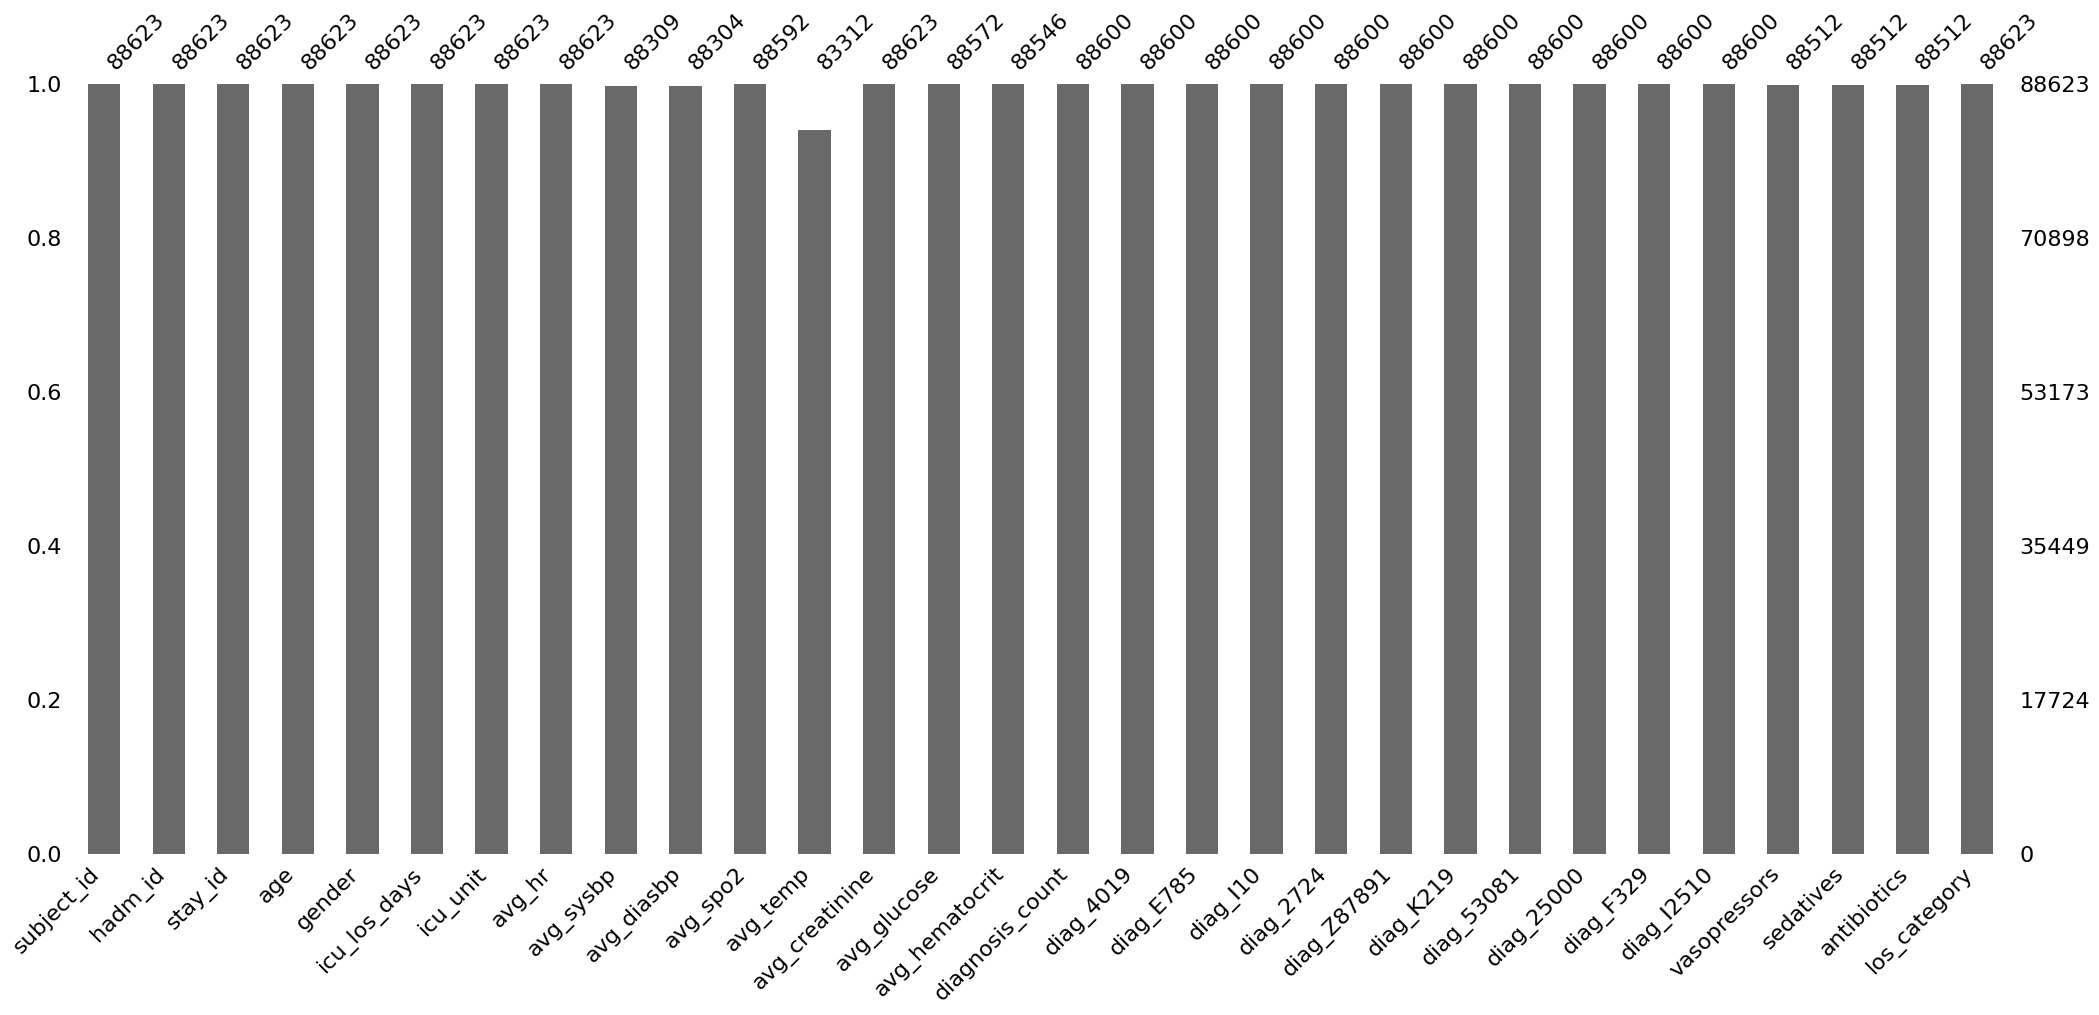

In [5]:
import missingno as msno

# Matrix plot
msno.matrix(analysis_df)
plt.show()

# Bar plot of missing values
msno.bar(analysis_df)
plt.show()

## Data Preprocessing and Train-Test Split for ICU LOS Prediction

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

categorical_cols = ['gender', 'icu_unit']
# -------------------------------
#  One-Hot Encoding for categorical features
# -------------------------------
icu_df = pd.get_dummies(icu_df, columns=categorical_cols, drop_first=True)

# ------------------------------
# 7. Min-max normalization (only numeric columns)
# ------------------------------
# Select numeric columns only
numeric_cols = analysis_df.select_dtypes(include=["int64", "float64"]).columns

# Normalize only those
analysis_df[numeric_cols] = (analysis_df[numeric_cols] - analysis_df[numeric_cols].min()) / \
                            (analysis_df[numeric_cols].max() - analysis_df[numeric_cols].min())

# -----------------------------------
# 2. Feature / Target Split
# -----------------------------------
X = analysis_df.drop(columns=['icu_los_days', 'los_category', 'stay_id', 'hadm_id', 'subject_id'])
y = analysis_df['los_category']

# Ensure X has no categorical dtype columns
for col in X.select_dtypes(include=['category']).columns:
    X[col] = X[col].cat.codes

# -------------------------------
# Handle missing values
# -------------------------------
# Numeric: fill with median
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# -------------------------------
# Outlier Treatment (IQR capping)
# -------------------------------
for col in numeric_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    X[col] = np.clip(X[col], lower, upper)

# -------------------------------
# Train-test split (stratify ensures balanced class distribution)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
missing_summary = X_train.isnull().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing_summary[missing_summary > 0])

Missing values per column:
 Series([], dtype: int64)


## Applying SMOTE to handle class imbalance

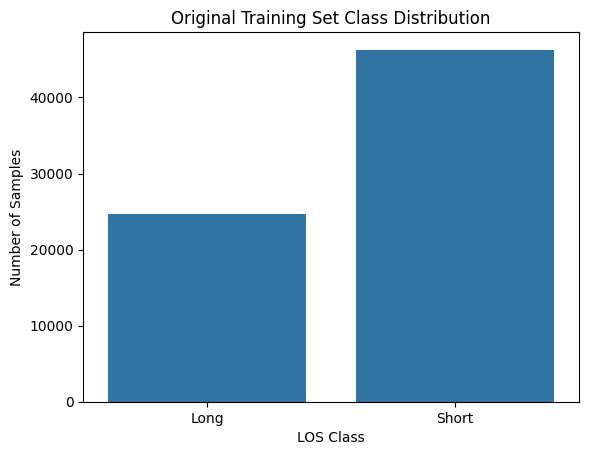

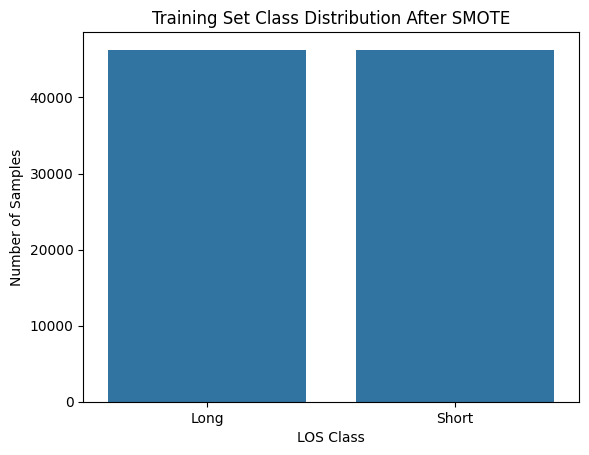

In [11]:
# -----------------------------
# Original class distribution
# -----------------------------
orig_counts = Counter(y_train)
# Map keys to readable labels
orig_counts_mapped = {label_map[k]: v for k, v in orig_counts.items()}

sns.barplot(x=list(orig_counts_mapped.keys()), y=list(orig_counts_mapped.values()))
plt.title("Original Training Set Class Distribution")
plt.xlabel("LOS Class")
plt.ylabel("Number of Samples")
plt.show()

# -----------------------------
# 2. Apply SMOTE on training data
# -----------------------------

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# -----------------------------
# After SMOTE
# -----------------------------
smote_counts = Counter(y_train_res)
smote_counts_mapped = {label_map[k]: v for k, v in smote_counts.items()}

sns.barplot(x=list(smote_counts_mapped.keys()), y=list(smote_counts_mapped.values()))
plt.title("Training Set Class Distribution After SMOTE")
plt.xlabel("LOS Class")
plt.ylabel("Number of Samples")
plt.show()


## Scale features (for KNN)

In [12]:
# -----------------------------
# 3. Scale features (for KNN)
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

## Machine Learning Model Training, Evaluation, and Feature Importance

Running RandomForest with GridSearchCV...


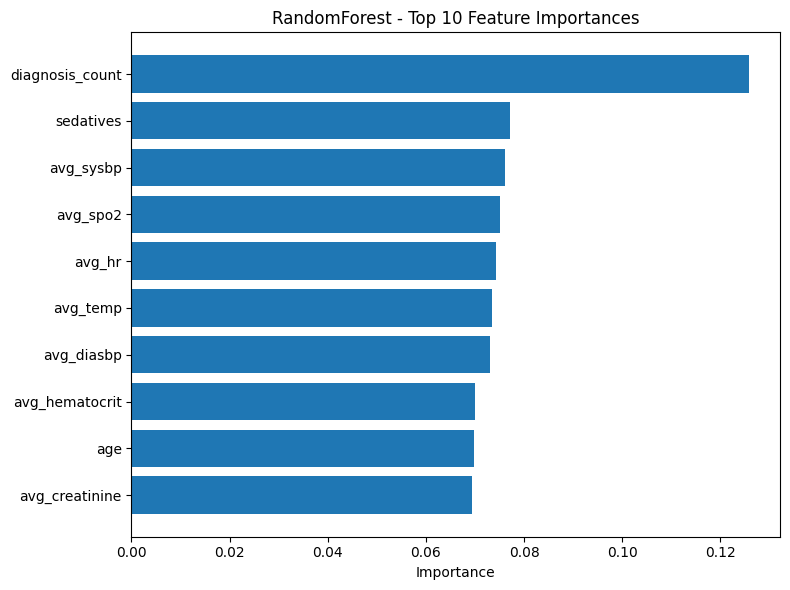

--- RandomForest ---
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Classification Report:
              precision    recall  f1-score   support

  Short Stay       0.80      0.82      0.81     11570
   Long Stay       0.65      0.62      0.64      6155

    accuracy                           0.75     17725
   macro avg       0.73      0.72      0.73     17725
weighted avg       0.75      0.75      0.75     17725

Confusion Matrix:
[[9535 2035]
 [2316 3839]]


Running XGBoost with GridSearchCV...


C:\Users\itsad\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [12:42:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


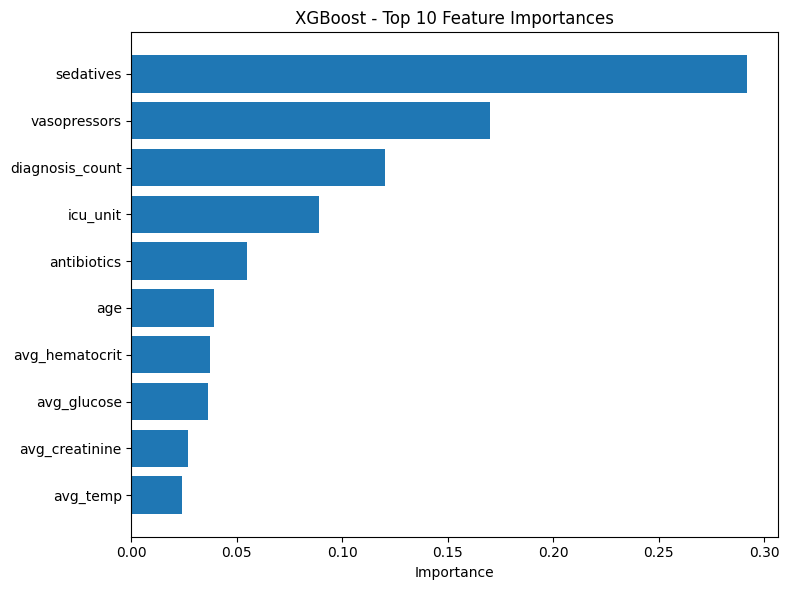

--- XGBoost ---
Best params: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000}
Classification Report:
              precision    recall  f1-score   support

  Short Stay       0.80      0.83      0.82     11570
   Long Stay       0.66      0.60      0.63      6155

    accuracy                           0.75     17725
   macro avg       0.73      0.72      0.72     17725
weighted avg       0.75      0.75      0.75     17725

Confusion Matrix:
[[9637 1933]
 [2432 3723]]


Running KNN with GridSearchCV...


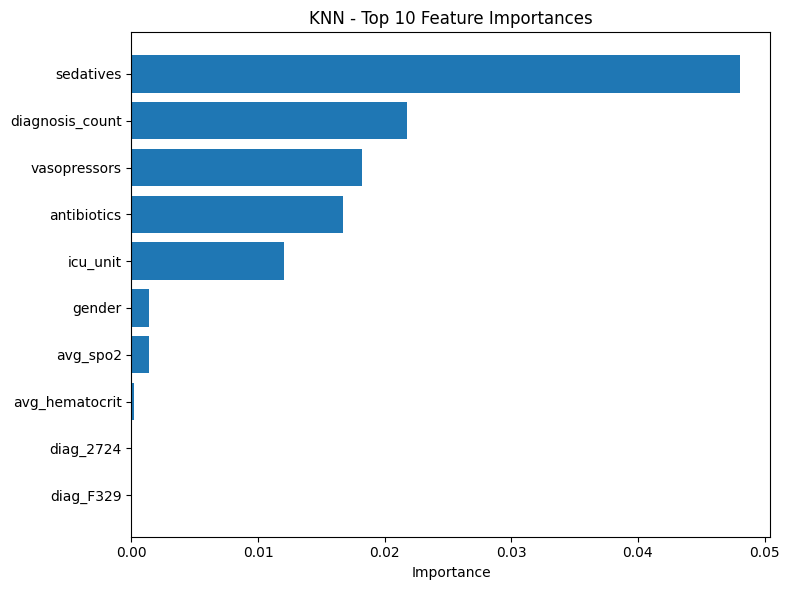

--- KNN ---
Best params: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Classification Report:
              precision    recall  f1-score   support

  Short Stay       0.79      0.70      0.74     11570
   Long Stay       0.54      0.65      0.59      6155

    accuracy                           0.68     17725
   macro avg       0.66      0.68      0.67     17725
weighted avg       0.70      0.68      0.69     17725

Confusion Matrix:
[[8107 3463]
 [2149 4006]]


Running LogisticRegression with GridSearchCV...


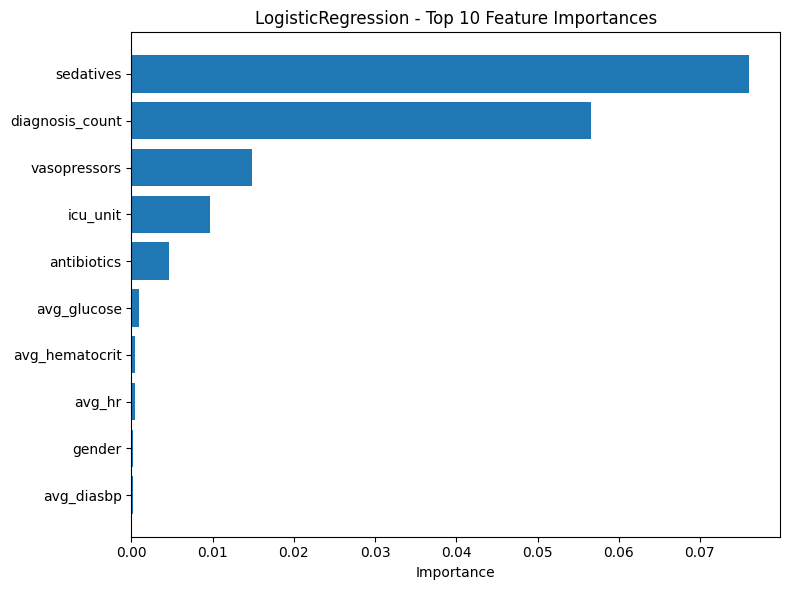

--- LogisticRegression ---
Best params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Classification Report:
              precision    recall  f1-score   support

  Short Stay       0.80      0.75      0.78     11570
   Long Stay       0.58      0.65      0.61      6155

    accuracy                           0.72     17725
   macro avg       0.69      0.70      0.69     17725
weighted avg       0.72      0.72      0.72     17725

Confusion Matrix:
[[8708 2862]
 [2176 3979]]




In [13]:
from sklearn.inspection import permutation_importance

# ----------------------------
# 2. Define models and hyperparameter grids
# ----------------------------
models = {
    "RandomForest": (RandomForestClassifier(random_state=42), {
        "n_estimators": [100, 300, 500],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    }),
    "XGBoost": (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="mlogloss"), {
        "n_estimators": [500, 1000],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5, 7]
    }),
    "KNN": (KNeighborsClassifier(), {
        "n_neighbors": [3, 5, 7],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"]
    }),
    "LogisticRegression": (LogisticRegression(max_iter=1000, random_state=42), {
        "C": [0.01, 0.1, 1, 10],
        "penalty": ["l2"],
        "solver": ["lbfgs", "liblinear"]
    })
}


# ----------------------------
# 3. Run GridSearchCV, evaluate, and calculate feature importance
# ----------------------------
results = []

for name, (model, param_grid) in models.items():
    print(f"Running {name} with GridSearchCV...")
    
    # Choose scaled features for SVM/KNN, unscaled for tree-based
    X_tr, X_te = (X_train_scaled, X_test_scaled) if name in ["SVM","KNN"] else (X_train_res, X_test)
    
    grid = GridSearchCV(model, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
    grid.fit(X_tr, y_train_res)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_te)
    
    # ----------------------------
    # Feature Importance
    # ----------------------------
    if name in ["RandomForest", "XGBoost"]:
        feat_imp_df = pd.DataFrame({
            "feature": X_train_res.columns,
            "importance": best_model.feature_importances_
        }).sort_values(by="importance", ascending=False)
    else:
        perm_result = permutation_importance(best_model, X_te, y_test, n_repeats=10, random_state=42, scoring="accuracy")
        feat_imp_df = pd.DataFrame({
            "feature": X_train_res.columns,
            "importance": perm_result.importances_mean
        }).sort_values(by="importance", ascending=False)
    
    # ----------------------------
    # Plot feature importance
    # ----------------------------
    top_n = 10
    plt.figure(figsize=(8,6))
    plt.barh(feat_imp_df["feature"].head(top_n)[::-1], feat_imp_df["importance"].head(top_n)[::-1])
    plt.xlabel("Importance")
    plt.title(f"{name} - Top {top_n} Feature Importances")
    plt.tight_layout()
    plt.show()
    
    # ----------------------------
    # Print metrics
    # ----------------------------
    print(f"--- {name} ---")
    print("Best params:", grid.best_params_)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Short Stay','Long Stay']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")
    
    # Save results
    results.append({
        "model": name,
        "best_params": grid.best_params_,
        "y_pred": y_pred,
        "feature_importance": feat_imp_df
    })


## Model Evaluation

In [18]:
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -----------------------------
# 1. Compute metrics dynamically
# -----------------------------
metrics_list = []
for res in results:
    y_pred = res["y_pred"]
    metrics_list.append({
        "Method": res["model"],
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
        "MCC": matthews_corrcoef(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_pred)
    })

metrics_df = pd.DataFrame(metrics_list).set_index("Method")
print(metrics_df)

                    Accuracy        F1  Balanced Accuracy       MCC       AUC
Method                                                                       
RandomForest        0.754528  0.638291           0.723917  0.452954  0.723917
XGBoost             0.753738  0.630429           0.718902  0.447167  0.718902
KNN                 0.683385  0.588080           0.675772  0.338954  0.675772
LogisticRegression  0.715769  0.612342           0.699551  0.390311  0.699551


## Plotting Confusion matrices 

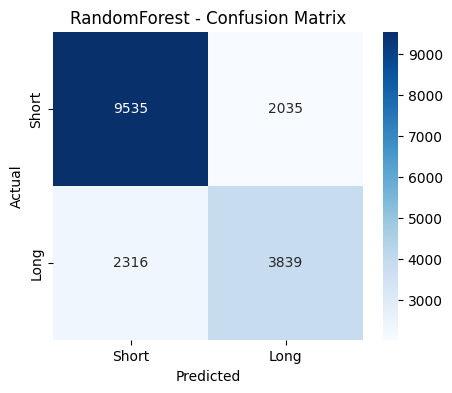

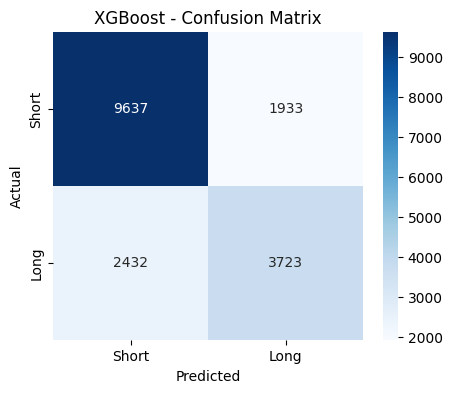

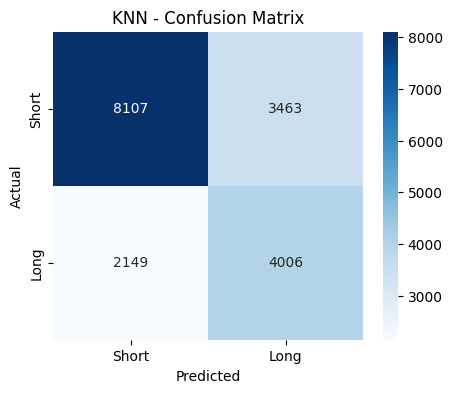

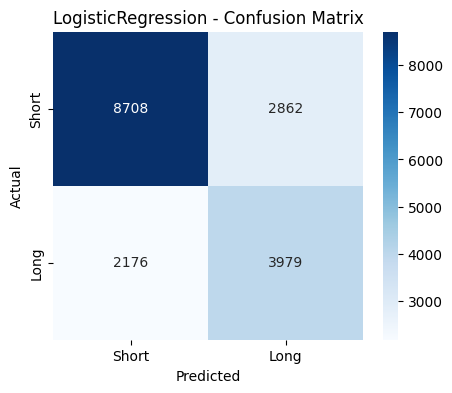

In [16]:
# -----------------------------
# 3. Confusion matrices 
# -----------------------------
for res in results:
    cm = confusion_matrix(y_test, res["y_pred"])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Short','Long'], yticklabels=['Short','Long'])
    plt.title(f"{res['model']} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



# Plotting Feature Importance

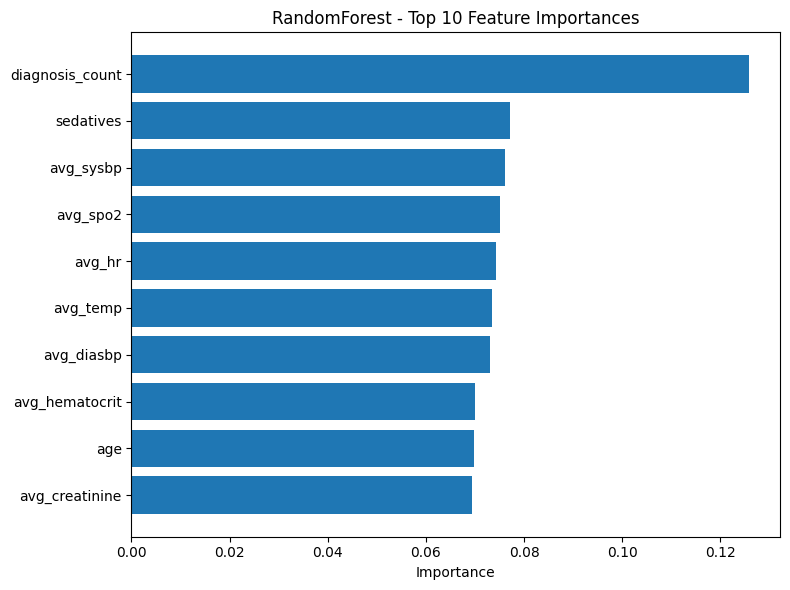

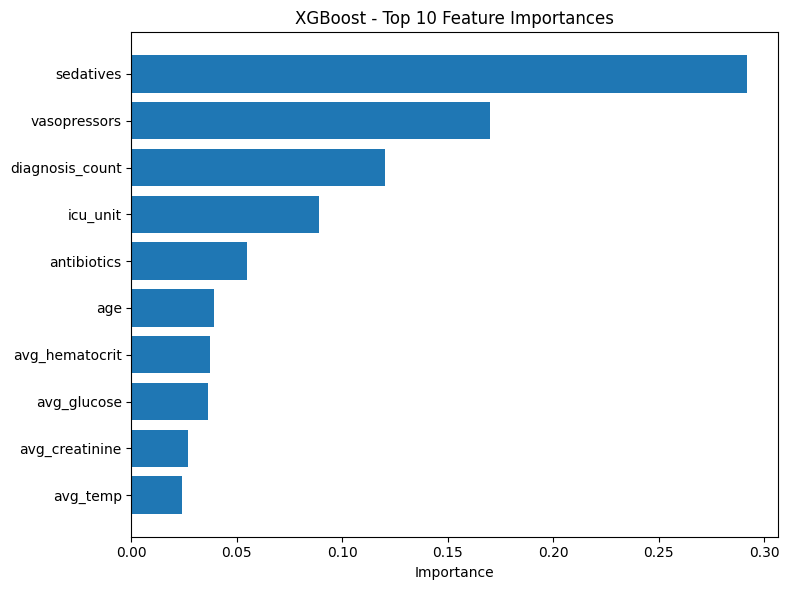

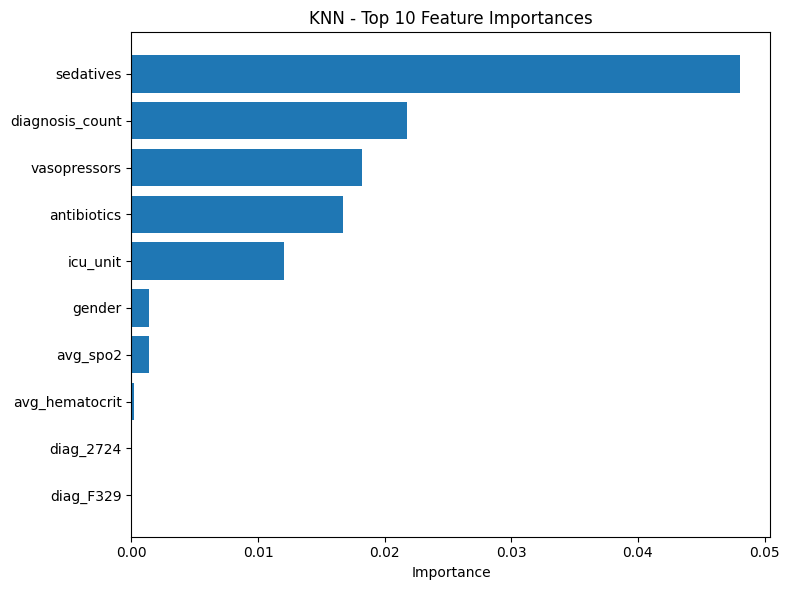

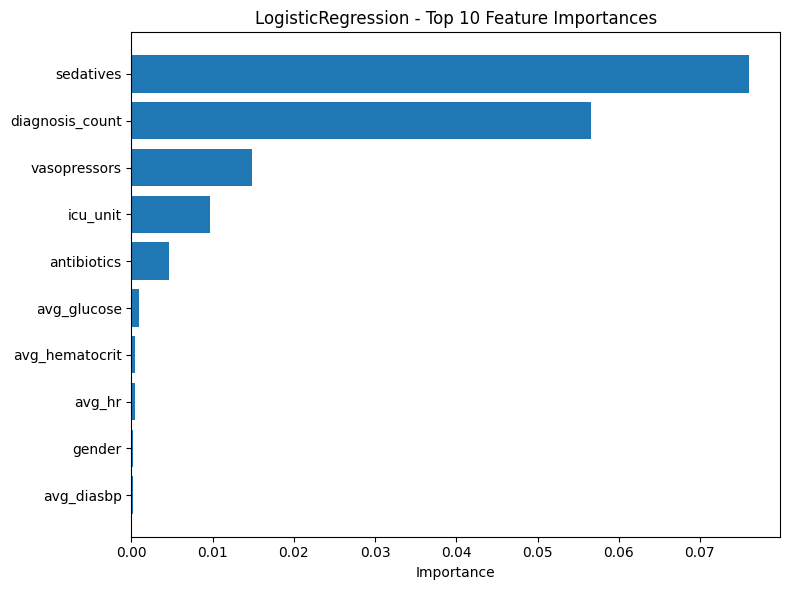

In [17]:
# -----------------------------
# 4. Feature importance
# -----------------------------
for res in results:
    feat_df = res["feature_importance"]
    top_n = 10
    plt.figure(figsize=(8,6))
    plt.barh(feat_df['feature'].head(top_n)[::-1], feat_df['importance'].head(top_n)[::-1])
    plt.title(f"{res['model']} - Top {top_n} Feature Importances")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


## Plotting ROC Curve for all models

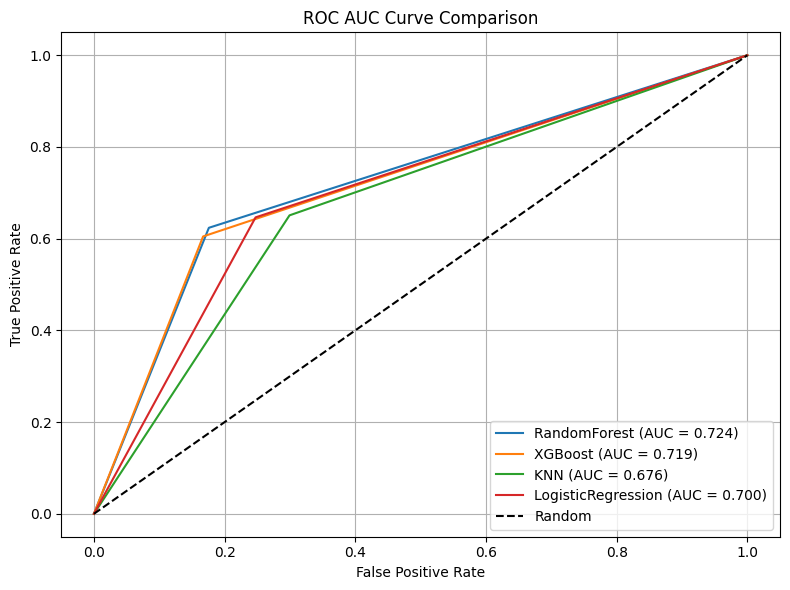

In [19]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

plt.figure(figsize=(8,6))

for res in results:
    y_true = y_test
    y_pred_proba = None
    
    # For tree-based or logistic regression, we can use predict_proba
    if hasattr(res['model'], 'predict_proba') or 'Logistic' in res['model'] or 'XGBoost' in res['model'] or 'RandomForest' in res['model']:
        try:
            y_pred_proba = res['best_estimator'].predict_proba(X_test)[:,1]
        except:
            y_pred_proba = None
    
    # Fallback: use predictions as probabilities for SVM (not ideal but works if only labels)
    if y_pred_proba is None:
        y_pred_proba = res['y_pred']
    
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{res['model']} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


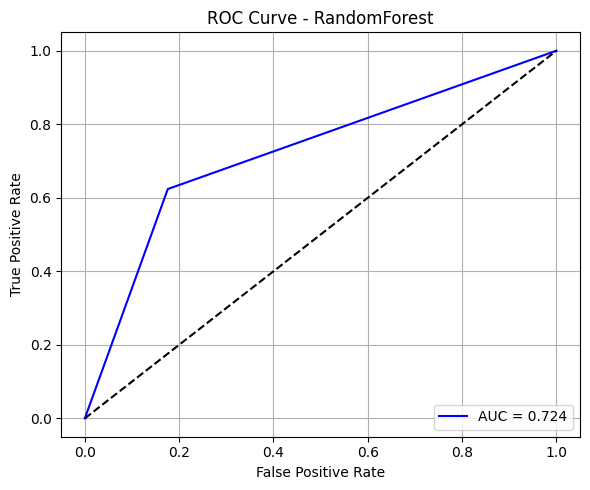

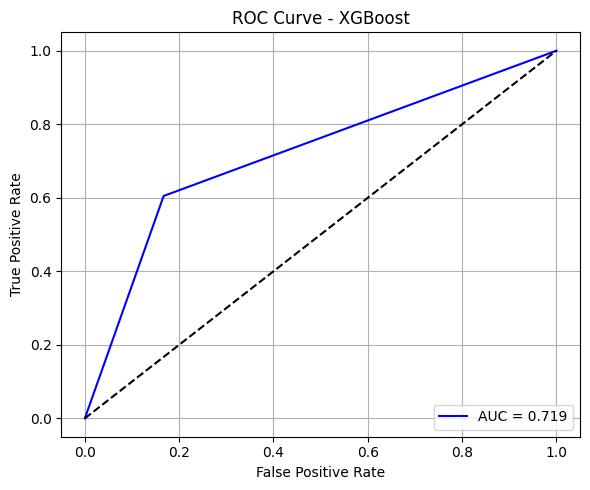

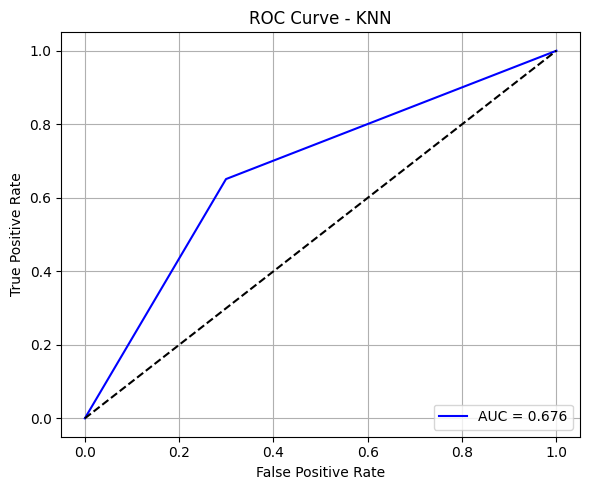

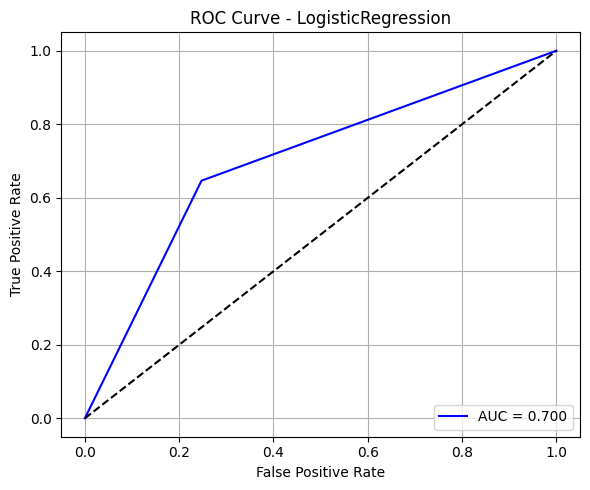

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

for res in results:
    y_true = y_test
    y_pred_proba = res.get('y_pred_proba', res['y_pred'])  # fallback if probabilities not saved

    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'ROC Curve - {res["model"]}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()